In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json

In [2]:
from workspace import nometools as nome
from workspace import utils

In [3]:
main_path = Path('..')
data_path = main_path / 'Data'
steric_path = main_path / 'superposition' / f'clash_1KX5_3PTA'
intersect_path = main_path / 'Data' / 'intersect_regions'
sliding_path = main_path / 'Data' / 'sliding_window_1kx5'

ref_path = data_path / 'GRCh38genome'
transcriptome_path = data_path / 'transcriptome'

#### Normalize Steric Clash

In [4]:
infile = steric_path / 'x_y_dict'
with open(infile, 'rb') as fin:
    x_y_clash_dict = pickle.load(fin)

x_y_clash_dict_norm_ = utils.normalize_clash_dict(x_y_clash_dict)

# meth_thres_range = [0, 10, 20]
meth_thres_range = [20, 10, 0]
clash_thres_range = [5, 10, 20, 50]

params = []
for clash_thres in clash_thres_range:
    for meth_thres in meth_thres_range:
        k = "c" + str(clash_thres) + "m" + str(meth_thres)
        params.append(k)

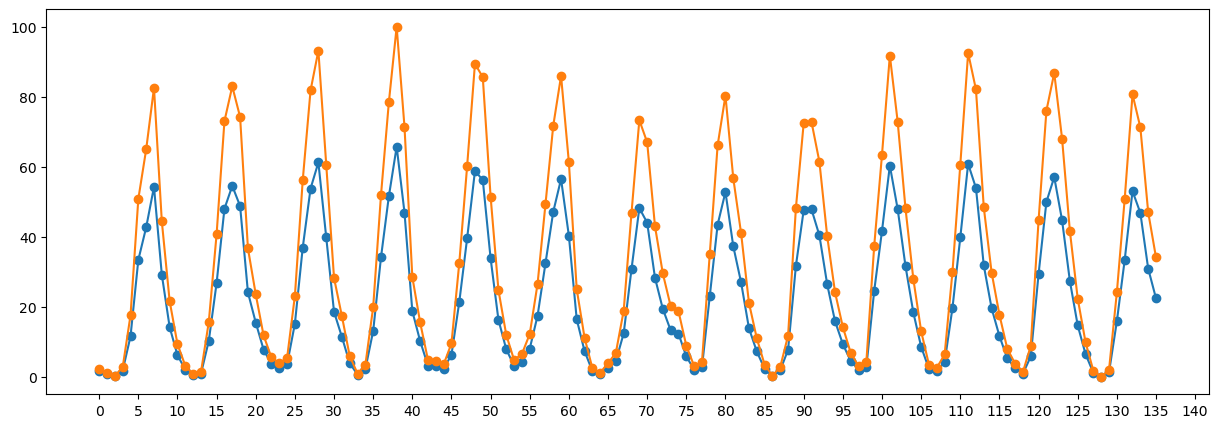

In [5]:
plt.figure(figsize=(15,5))
plt.plot(x_y_clash_dict.values(), marker='o')
plt.plot(x_y_clash_dict_norm_.values(), marker='o')
plt.xticks(range(0,len(x_y_clash_dict.values())+5,5))
plt.show()

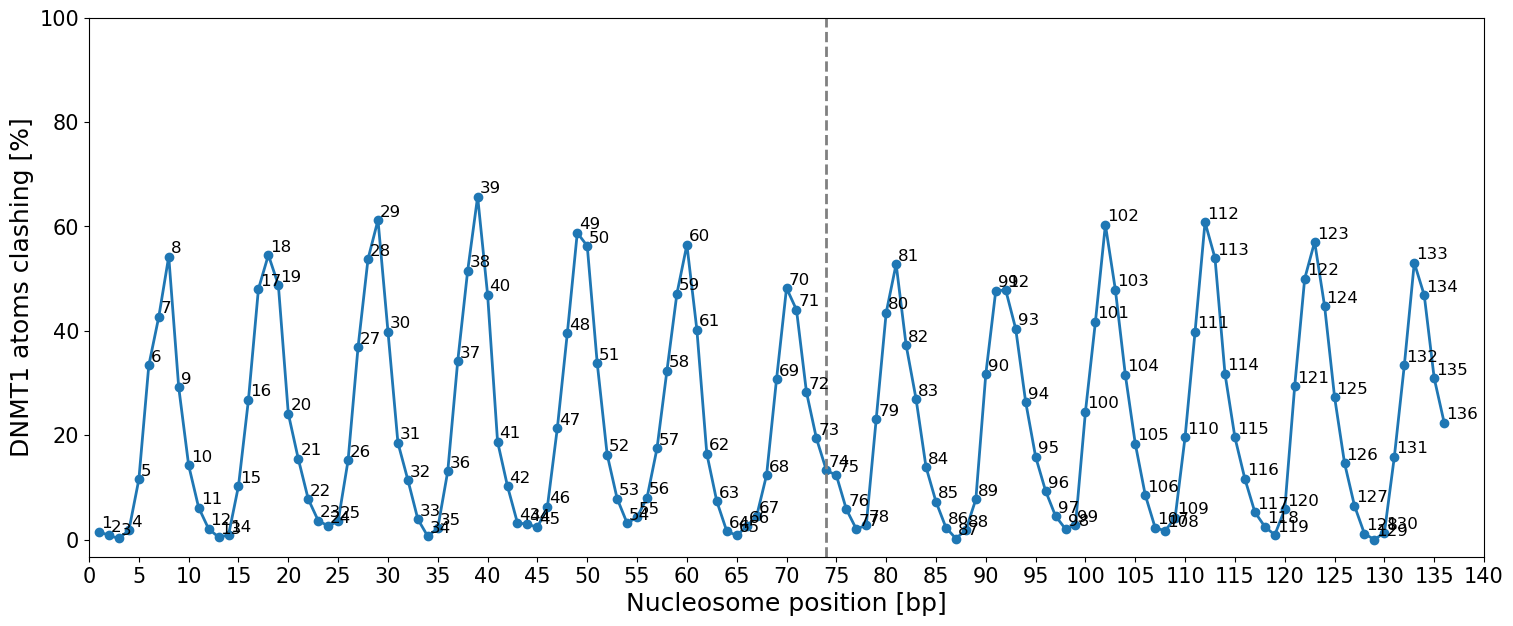

In [6]:
x = list(x_y_clash_dict.keys())
y = list(x_y_clash_dict.values())

fig = plt.figure(figsize=(18, 7))
ax = plt.subplot(111)

ax.plot(x, y, linestyle="-", marker="o", linewidth=2)
for pos in range(0,len(x)):
    ax.text(x[pos]+0.2, y[pos]+0.7, x[pos], fontsize=12)
    
plt.xlim(0,140)
plt.xticks(range(0,len(x)+5,5), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Nucleosome position [bp]", fontsize=18)
plt.ylabel("DNMT1 atoms clashing [%]", fontsize=18)
plt.ylim(top=100)

ax.axvline(x=74,c="grey",linewidth=2,linestyle="--")#4169e1

In [7]:
len(x_y_clash_dict.keys()), len(x_y_clash_dict_norm_.keys())

(136, 136)

#### Expression and Map

In [8]:
df_expression = pd.read_csv(transcriptome_path / 'LTC_HepG2_MonoCal_FA.rep1.TPM.txt', sep='\t', names=['id', 'expression'], header=0)
df_expression['gene_id'] = df_expression['id'].str.split(':').str[0]
df_expression.head()

,id,expression,gene_id
0,ENSG00000219391:AC019129.1,0.0,ENSG00000219391
1,ENSG00000224632:Z73361.1,0.0,ENSG00000224632
2,ENSG00000281691:RBM5-AS1,0.0,ENSG00000281691
3,ENSG00000222293:RNU2-36P,0.0,ENSG00000222293
4,ENSG00000283803:MIR3198-2,0.0,ENSG00000283803


In [9]:
# df_expression = pd.read_csv(transcriptome_path / 'GSM2343347.tsv', sep='\t')
# df_expression.head()

In [10]:
import json
from collections import defaultdict

In [11]:
with open(ref_path / 'transcript_to_gene.json', 'r') as file:
    transcript_to_gene = json.load(file)

transcript_to_gene_cleaned = {k.split('.')[0]:v.split('.')[0] for k,v in transcript_to_gene.items()}

In [12]:
gene_to_transcript = defaultdict(list)
for t, g in transcript_to_gene_cleaned.items():
    gene_to_transcript[g].append(t)

In [13]:
len(gene_to_transcript)

78724

In [14]:
mask_expressed = df_expression['expression'] > 0

def get_transcripts_list(series, map):
    t_list = []
    for g in series:
        t_list += map[g]

    return t_list

transcript_expressed = get_transcripts_list(df_expression.loc[mask_expressed, 'gene_id'], gene_to_transcript)
transcript_not_expressed = get_transcripts_list(df_expression.loc[~mask_expressed, 'gene_id'], gene_to_transcript)

In [15]:
# (38772, 88853)
len(transcript_expressed), len(transcript_not_expressed)

(38772, 88853)

In [16]:
transcript_expressed[:10]

['ENST00000317040',
 'ENST00000529939',
 'ENST00000528515',
 'ENST00000380254',
 'ENST00000346498',
 'ENST00000518734',
 'ENST00000519471',
 'ENST00000374212',
 'ENST00000316660',
 'ENST00000269518']

#### Cohen's D and P values

In [17]:
import scipy
from scipy import stats

def calculate_cohens_d(list_EXP,list_RAND):
    mEXP = np.mean(list_EXP)
    sdEXP = np.std(list_EXP)
    
    mRAND = np.mean(list_RAND)
    sdRAND = np.std(list_RAND)
    
    denom = np.sqrt(float(sdEXP**2 + sdRAND**2)/2.0)
    cohens_d = float(mEXP-mRAND)/float(denom + 1e-6)
    
    return cohens_d

def make_df_p_vals_cohens_d(df_scores_EXP, df_scores_RAND, params):
    column_names = ["nbr_CpGs", "parameter", "N_EXP", "N_RAND", "mean_EXP", "median_EXP", "std_EXP", "mean_RAND",
                    "median_RAND", "std_RAND", "cohens_d", "is_normal_EXP", "is_normal_RAND", "pval_ttest",
                    "t_stat", "pval_ranksums", "pval_ks_2samp"]
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []

    nbr_CpGs_list = list(set(list(df_scores_EXP["nbr_CpGs"])))

    for nbr_CpGs in nbr_CpGs_list:
        df_scores_EXP_tmp = df_scores_EXP.loc[df_scores_EXP["nbr_CpGs"] == nbr_CpGs]
        df_scores_RAND_tmp = df_scores_RAND.loc[df_scores_RAND["nbr_CpGs"] == nbr_CpGs]
                    
        for p in range(len(params)):
            par_name = params[p]
            EXP_scores = list(df_scores_EXP_tmp[par_name])
            RAND_scores = list(df_scores_RAND_tmp[par_name])
            
            info_dict["nbr_CpGs"].append(nbr_CpGs)
            info_dict["parameter"].append(par_name)
            
            info_dict["N_EXP"].append(len(EXP_scores))
            info_dict["N_RAND"].append(len(RAND_scores))
            
            info_dict["mean_EXP"].append(np.mean(EXP_scores))
            info_dict["median_EXP"].append(np.median(EXP_scores))
            info_dict["std_EXP"].append(np.std(EXP_scores))
            
            info_dict["mean_RAND"].append(np.mean(RAND_scores))
            info_dict["median_RAND"].append(np.median(RAND_scores))
            info_dict["std_RAND"].append(np.std(RAND_scores))
            
            #EFFECT SIZE
            cohens_d = calculate_cohens_d(EXP_scores, RAND_scores)
            info_dict["cohens_d"].append(cohens_d)
            
            #STAT TESTS
            #is normal distributed? This function tests the null hypothesis that a sample comes from a normal distribution. If small -> ost likely not normal dustributed
            pval_normal_EXP = stats.normaltest(EXP_scores)[1] if len(EXP_scores) >= 8 else -1
            pval_normal_RAND = stats.normaltest(RAND_scores)[1] if len(EXP_scores) >= 8 else -1
            
            #students t
            ttest_res = stats.ttest_ind(EXP_scores,RAND_scores,equal_var = False)
            t_stat = ttest_res[0]
            p_val_ttest = float(ttest_res[1])/2.0
            
            #ranksums, kstest
            ranksums = scipy.stats.ranksums(EXP_scores,RAND_scores)[1]
            ks_2samp = scipy.stats.ks_2samp(EXP_scores,RAND_scores)[1]
    
            info_dict["is_normal_EXP"].append(pval_normal_EXP)
            info_dict["is_normal_RAND"].append(pval_normal_RAND)
            info_dict["pval_ttest"].append(p_val_ttest)
            info_dict["t_stat"].append(t_stat)
            info_dict["pval_ranksums"].append(ranksums)
            info_dict["pval_ks_2samp"].append(ks_2samp)
            
    #Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["nbr_CpGs"])),columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]

    return df

In [18]:
region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
# region = 'intron.2.start'

In [19]:
expression = True
rest = False

In [20]:
df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

In [21]:
df_NDR_score_exp.head()

,refid_NOR,trans_id,refid,NOR_nbr,window_nbr,nbr_CpGs,nuc_rel_center,nuc_region_length,c5m0,c5m10,c5m20,c10m0,c10m10,c10m20,c20m0,c20m10,c20m20,c50m0,c50m10,c50m20
0,ENST00000706828.1-1,ENST00000706828.1-35453166,ENST00000706828.1,1,1,7,-214.0,841,0.571429,0.571429,0.571429,0.428571,0.428571,0.428571,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714
1,ENST00000706828.1-1,ENST00000706828.1-35453166,ENST00000706828.1,1,2,8,-214.0,841,0.875000,0.875000,0.875000,0.750000,0.750000,0.750000,0.500000,0.500000,0.500000,0.125000,0.125000,0.125000
2,ENST00000706828.1-1,ENST00000706828.1-35453166,ENST00000706828.1,1,3,9,-214.0,841,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.555556,0.555556,0.555556,0.000000,0.000000,0.000000
3,ENST00000706828.1-1,ENST00000706828.1-35453166,ENST00000706828.1,1,4,9,-214.0,841,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.666667,0.666667,0.666667,0.111111,0.111111,0.111111
4,ENST00000706828.1-1,ENST00000706828.1-35453166,ENST00000706828.1,1,5,9,-214.0,841,0.777778,0.777778,0.777778,0.777778,0.777778,0.777778,0.777778,0.777778,0.777778,0.333333,0.333333,0.333333


In [22]:
print(f"LNDR exp trasncripts: {df_NDR_score_exp['refid'].unique().shape}")
print(f"LNDR random trasncripts: {df_NDR_score_random['refid'].unique().shape}")

print(f"HNDR exp trasncripts: {df_NOR_score_exp['refid'].unique().shape}")
print(f"HNDR random trasncripts: {df_NOR_score_random['refid'].unique().shape}")

LNDR exp trasncripts: (25164,)
LNDR random trasncripts: (25164,)
HNDR exp trasncripts: (3886,)
HNDR random trasncripts: (3886,)


In [23]:
if not rest:
    if expression:
        df_NDR_score_exp = df_NDR_score_exp[df_NDR_score_exp['refid'].str.split('.').str[0].isin(transcript_expressed)]
        df_NDR_score_random = df_NDR_score_random[df_NDR_score_random['refid'].str.split('.').str[0].isin(transcript_expressed)]
        df_NOR_score_exp = df_NOR_score_exp[df_NOR_score_exp['refid'].str.split('.').str[0].isin(transcript_expressed)]
        df_NOR_score_random = df_NOR_score_random[df_NOR_score_random['refid'].str.split('.').str[0].isin(transcript_expressed)]
    else:
        df_NDR_score_exp = df_NDR_score_exp[df_NDR_score_exp['refid'].str.split('.').str[0].isin(transcript_not_expressed)]
        df_NDR_score_random = df_NDR_score_random[df_NDR_score_random['refid'].str.split('.').str[0].isin(transcript_not_expressed)]
        df_NOR_score_exp = df_NOR_score_exp[df_NOR_score_exp['refid'].str.split('.').str[0].isin(transcript_not_expressed)]
        df_NOR_score_random = df_NOR_score_random[df_NOR_score_random['refid'].str.split('.').str[0].isin(transcript_not_expressed)]
else:
    print('Warning: rest')
    df_NDR_score_exp = df_NDR_score_exp[~df_NDR_score_exp['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]
    df_NDR_score_random = df_NDR_score_random[~df_NDR_score_random['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]
    df_NOR_score_exp = df_NOR_score_exp[~df_NOR_score_exp['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]
    df_NOR_score_random = df_NOR_score_random[~df_NOR_score_random['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]

In [24]:
if not rest:
    if expression:
        print(f"expressed LNDR exp trasncripts: {df_NDR_score_exp['refid'].unique().shape}")
        print(f"expressed LNDR random trasncripts: {df_NDR_score_random['refid'].unique().shape}")
        print(f"expressed HNDR exp trasncripts: {df_NOR_score_exp['refid'].unique().shape}")
        print(f"expressed HNDR random trasncripts: {df_NOR_score_random['refid'].unique().shape}")
    else:
        print(f"non expressed LNDR exp trasncripts: {df_NDR_score_exp['refid'].unique().shape}")
        print(f"non expressed LNDR random trasncripts: {df_NDR_score_random['refid'].unique().shape}")
        print(f"non expressed HNDR exp trasncripts: {df_NOR_score_exp['refid'].unique().shape}")
        print(f"non expressed HNDR random trasncripts: {df_NOR_score_random['refid'].unique().shape}")
else:
    print('Warning: rest')
    print(f"rest LNDR exp trasncripts: {df_NDR_score_exp['refid'].unique().shape}")
    print(f"rest LNDR random trasncripts: {df_NDR_score_random['refid'].unique().shape}")
    print(f"rest HNDR exp trasncripts: {df_NOR_score_exp['refid'].unique().shape}")
    print(f"rest HNDR random trasncripts: {df_NOR_score_random['refid'].unique().shape}")

expressed LNDR exp trasncripts: (10488,)
expressed LNDR random trasncripts: (10488,)
expressed HNDR exp trasncripts: (1800,)
expressed HNDR random trasncripts: (1800,)


In [25]:
df_NDR_pvalues = make_df_p_vals_cohens_d(df_NDR_score_exp, df_NDR_score_random, params)

/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1808: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)
/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation

In [26]:
df_NOR_pvalues = make_df_p_vals_cohens_d(df_NOR_score_exp, df_NOR_score_random, params)

In [27]:
df_NDR_pvalues.head()

,nbr_CpGs,parameter,N_EXP,N_RAND,mean_EXP,median_EXP,std_EXP,mean_RAND,median_RAND,std_RAND,cohens_d,is_normal_EXP,is_normal_RAND,pval_ttest,t_stat,pval_ranksums,pval_ks_2samp
0,1,c5m20,415831,415831,0.549877,1.0,0.497506,0.532774,1.0,0.498925,0.034329,0.0,0.0,1.611271e-55,15.653095,1.410155e-41,2.925373e-53
1,1,c5m10,415831,415831,0.535821,1.0,0.498715,0.518886,1.0,0.499643,0.033925,0.0,0.0,2.852802e-54,15.469113,8.503437e-41,3.170565e-52
2,1,c5m0,415831,415831,0.535530,1.0,0.498736,0.518691,1.0,0.499651,0.033731,0.0,0.0,1.119681e-53,15.380812,2.355418e-40,1.224454e-51
3,1,c10m20,415831,415831,0.526851,1.0,0.499279,0.518011,1.0,0.499676,0.017699,0.0,0.0,3.512847e-16,8.070232,2.915874e-12,1.531917e-14
4,1,c10m10,415831,415831,0.518994,1.0,0.499639,0.510481,1.0,0.499890,0.017034,0.0,0.0,4.016929e-15,7.767188,1.775088e-11,1.622991e-13


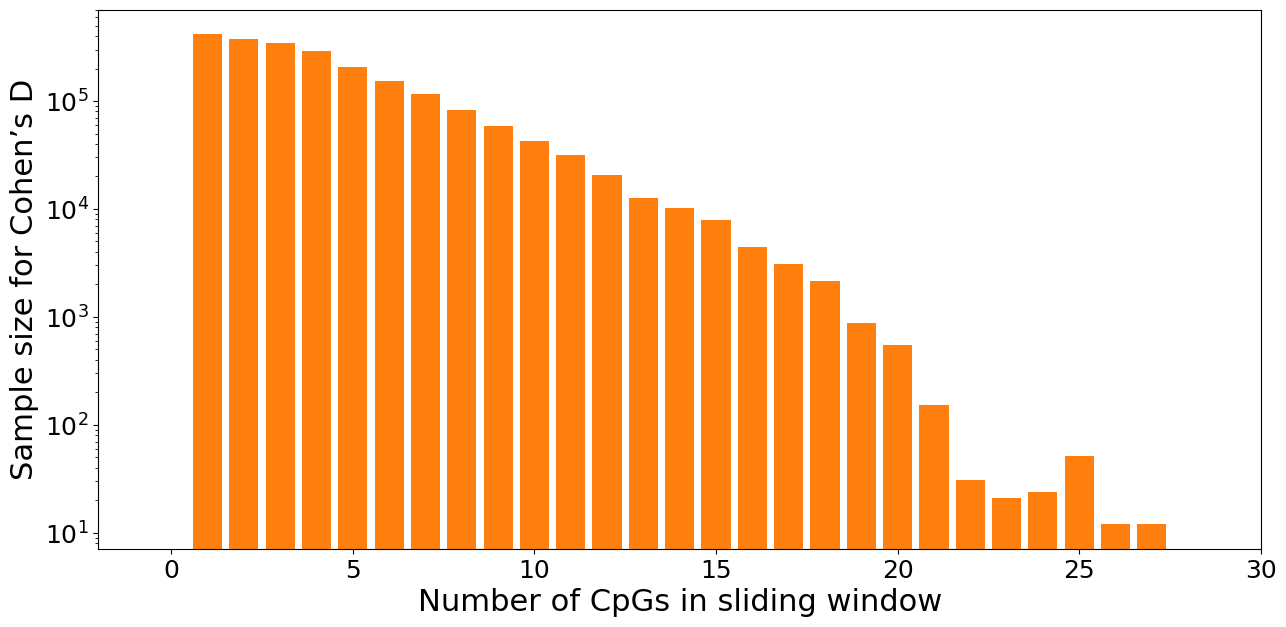

In [28]:
plt.figure(figsize=(15,7))
groups = df_NDR_pvalues.groupby(by='parameter')
for par, df_tmp in groups:
    plt.bar(df_tmp['nbr_CpGs'], df_tmp['N_EXP'], label=par)

plt.xlim(-2,30)
# plt.legend()
plt.xlabel('Number of CpGs in sliding window', fontsize=22)
plt.ylabel('Sample size for Cohen’s D', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')

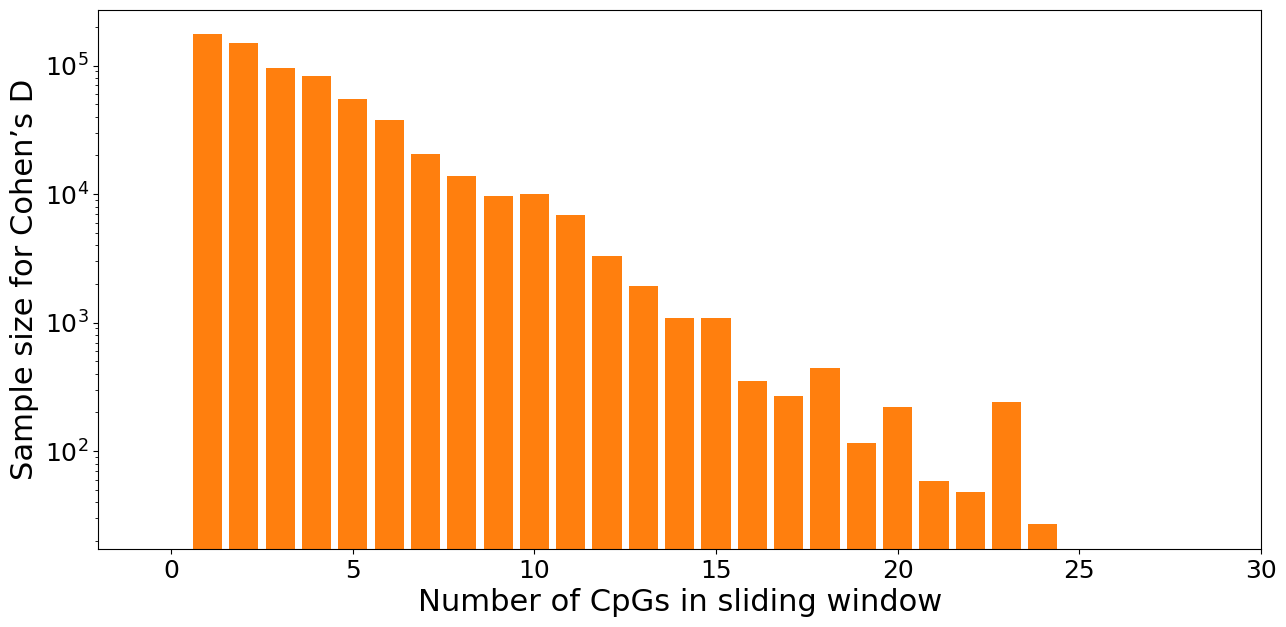

In [29]:
plt.figure(figsize=(15,7))
groups = df_NOR_pvalues.groupby(by='parameter')
for par, df_tmp in groups:
    plt.bar(df_tmp['nbr_CpGs'], df_tmp['N_EXP'], label=par)
plt.xlim(-2,30)
# plt.legend()
plt.xlabel('Number of CpGs in sliding window', fontsize=22)
plt.ylabel('Sample size for Cohen’s D', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')

In [30]:
def plot_nbr_CpGs_cohensd(df_values, params):
    plt.figure(figsize=(15,7))
    ax = plt.subplot(1,1,1)
    
    nbr_CpGs_list = sorted(list(set(list(df_values["nbr_CpGs"]))))

    for par_name in params:
        
        df_values_tmp = df_values.loc[df_values["parameter"] == par_name]
        
        x_nbr_cpg_vals = list(df_values_tmp["nbr_CpGs"])
        y_cohens_d_vals = list(df_values_tmp["cohens_d"])
        
        if "m0" in par_name:
            c = "#117A65"
        if "m10" in par_name:
            c = "#45B39D"
        if "m20" in par_name:
            c = "#EB984E"
        if "c5" in par_name:
            m = "*"
            ms = 15
        if "c10" in par_name:
            m = "^"
            ms = 10
        if "c20" in par_name:
            m = "s"
            ms = 10
        if "c50" in par_name:
            m = "o"
            ms = 10
        
        
        plt.plot(x_nbr_cpg_vals, y_cohens_d_vals, linestyle="-", color=c, marker=m, markersize=ms, label=par_name)
    
    
    plt.axhline(y=0.2, linewidth=1, color = '#2C3E50',linestyle='--')
    plt.axhline(y=0.5, linewidth=1, color = '#2C3E50',linestyle='--')
    plt.axhline(y=0.8, linewidth=1, color = '#2C3E50',linestyle='--')
    
    e = 0.02
    ax.text(-1.8,0.2+e, "Small ES")
    ax.text(-1.8,0.5+e, "Medium ES")
    ax.text(-1.8,0.8+e, "Large ES")

    ax.set_ylabel("Cohen's D", fontsize=22)
    ax.set_xlabel("Number of CpGs in sliding window", fontsize=22)   

    plt.xlim(-2,30)
    plt.ylim(-5,5)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    legend = ax.legend(loc="lower left", ncol=4, frameon = 1, prop={'size':18})
    legend.get_frame().set_facecolor('white')

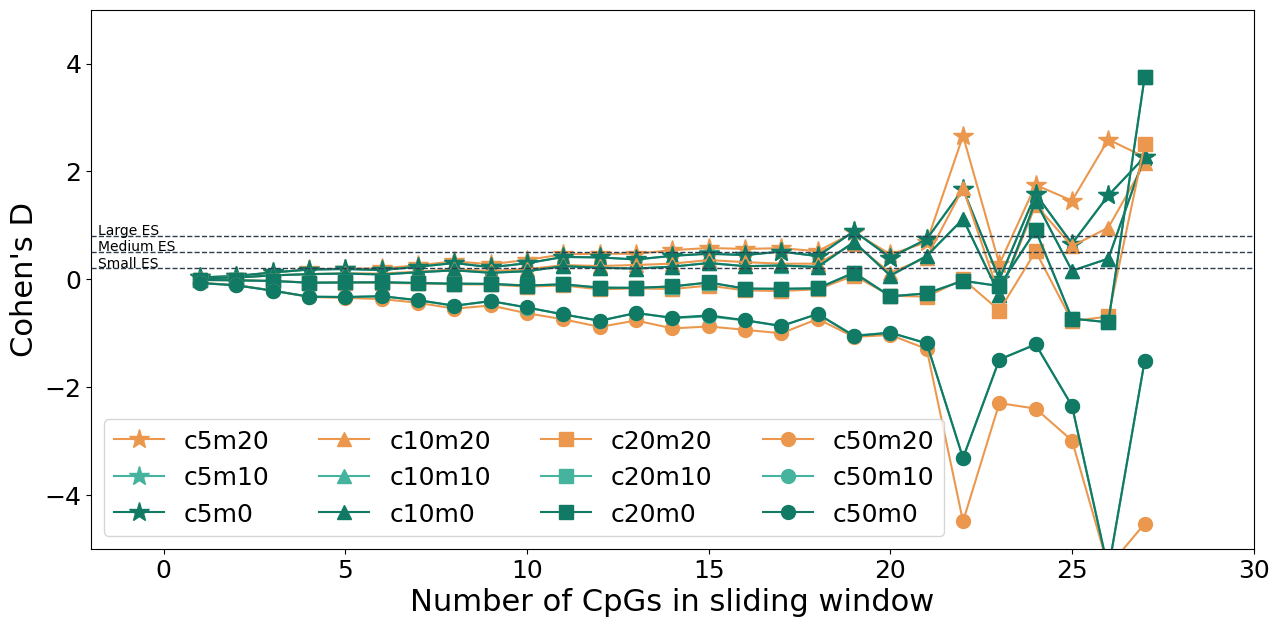

In [31]:
plot_nbr_CpGs_cohensd(df_NDR_pvalues, params)

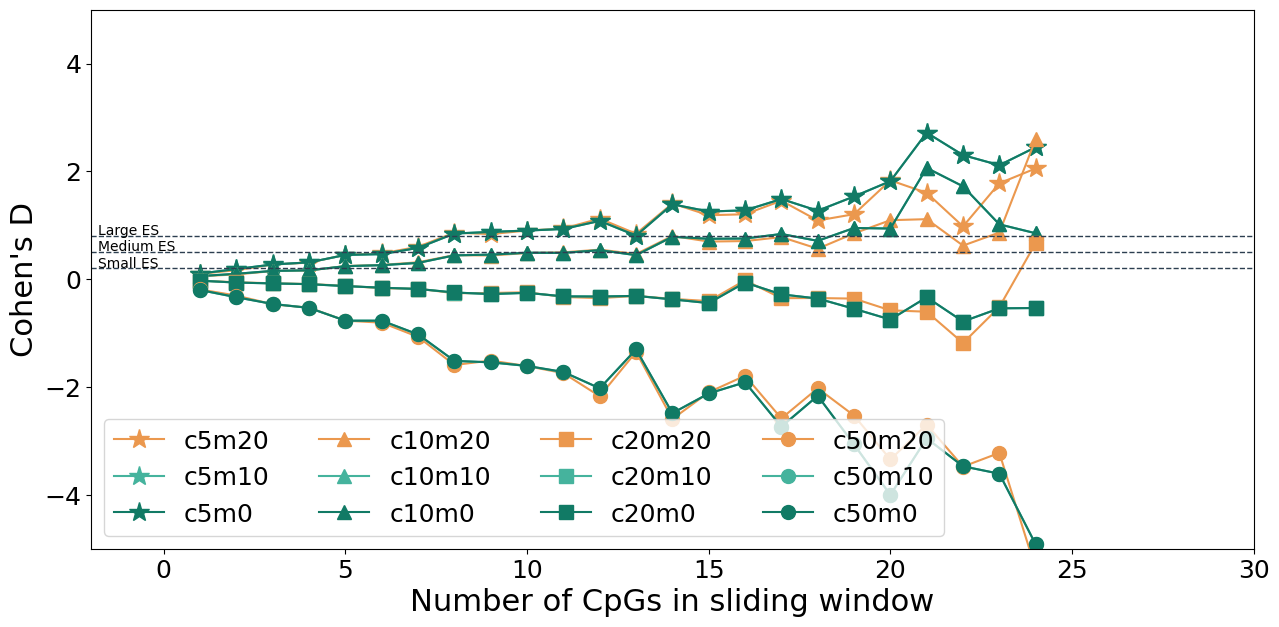

In [32]:
plot_nbr_CpGs_cohensd(df_NOR_pvalues, params)

In [ ]:
def plot_pvals_cohensd(df_values,params):
    
    plt.figure(figsize=(15,7))
    ax = plt.subplot(1,1,1)
    
    nbr_CpGs_list = sorted(list(set(list(df_values["nbr_CpGs"]))))
    
    for par_name in params:
        df_values_tmp = df_values.loc[df_values["parameter"] == par_name]
        
        x_nbr_cpg_vals = list(df_values_tmp["nbr_CpGs"])
        y_pvals_vals = list(df_values_tmp["pval_ranksums"])
        
        y_pvals_log = [-np.log10(p_val) if p_val != 0.0 else 310 for p_val in y_pvals_vals]
        # print(min([p_val for p_val in y_pvals_vals]))
        # y_pvals_log = [-np.log10(p_val) for p_val in y_pvals_vals]
        
        if "m0" in par_name:
            c = "#117A65"
        if "m10" in par_name:
            c = "#45B39D"
        if "m20" in par_name:
            c = "#EB984E"
        if "c5" in par_name:
            m = "*"
            ms = 15
        if "c10" in par_name:
            m = "^"
            ms = 10
        if "c20" in par_name:
            m = "s"
            ms = 10
        if "c50" in par_name:
            m = "o"
            ms = 10
        
        
        plt.plot(x_nbr_cpg_vals,y_pvals_log,linestyle="-",color=c,marker=m,markersize=ms,label=par_name)
    
    
    #plt.axhline(y=-np.log10(0.05), linewidth=1, color = '#5D6D7E',linestyle='-')
    #plt.axhline(y=-np.log10(0.01), linewidth=1, color = '#515A5A',linestyle='-')

    ax.set_ylabel("-log10(P-value)", fontsize=22)
    ax.set_xlabel("Number of CpGs in sliding window", fontsize=22)   

    plt.xlim(-2, 30)
    plt.ylim(0, 450)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    legend = ax.legend(loc="upper right",ncol=4,frameon = 1,prop={'size':18})
    legend.get_frame().set_facecolor('white')

In [ ]:
plot_pvals_cohensd(df_NDR_pvalues, params)

In [ ]:
plot_pvals_cohensd(df_NOR_pvalues, params)

#### Cohen's D Calculation Table

In [ ]:
import scipy
from scipy import stats

def calculate_cohens_d(list_EXP,list_RAND):
    mEXP = np.mean(list_EXP)
    sdEXP = np.std(list_EXP)
    
    mRAND = np.mean(list_RAND)
    sdRAND = np.std(list_RAND)
    
    denom = np.sqrt(float(sdEXP**2 + sdRAND**2)/2.0)
    cohens_d = float(mEXP-mRAND)/float(denom + 1e-6)
    
    return cohens_d

def make_df_cohens_d(df_scores_EXP, df_scores_RAND, params):
    column_names = ["parameter", "N_EXP", "N_RAND", "mean_EXP", "median_EXP", "std_EXP", "mean_RAND",
                    "median_RAND", "std_RAND", "cohens_d", "is_normal_EXP", "is_normal_RAND", "pval_ttest",
                    "t_stat", "pval_ranksums", "pval_ks_2samp"]
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []
    
    df_scores_EXP_tmp = df_scores_EXP.loc[df_scores_EXP['nbr_CpGs'].between(10,20)]
    df_scores_RAND_tmp = df_scores_RAND.loc[df_scores_RAND['nbr_CpGs'].between(10,20)]
                    
    for p in range(len(params)):
        par_name = params[p]
        EXP_scores = list(df_scores_EXP_tmp[par_name])
        RAND_scores = list(df_scores_RAND_tmp[par_name])
        
        # info_dict["nbr_CpGs"].append(nbr_CpGs)
        info_dict["parameter"].append(par_name)
        
        info_dict["N_EXP"].append(len(EXP_scores))
        info_dict["N_RAND"].append(len(RAND_scores))
        
        info_dict["mean_EXP"].append(np.mean(EXP_scores))
        info_dict["median_EXP"].append(np.median(EXP_scores))
        info_dict["std_EXP"].append(np.std(EXP_scores))
        
        info_dict["mean_RAND"].append(np.mean(RAND_scores))
        info_dict["median_RAND"].append(np.median(RAND_scores))
        info_dict["std_RAND"].append(np.std(RAND_scores))
        
        #EFFECT SIZE
        cohens_d = calculate_cohens_d(EXP_scores, RAND_scores)
        info_dict["cohens_d"].append(cohens_d)
        
        #STAT TESTS
        #is normal distributed? This function tests the null hypothesis that a sample comes from a normal distribution. If small -> ost likely not normal dustributed
        pval_normal_EXP = stats.normaltest(EXP_scores)[1] if len(EXP_scores) >= 8 else -1
        pval_normal_RAND = stats.normaltest(RAND_scores)[1] if len(EXP_scores) >= 8 else -1
        
        #students t
        ttest_res = stats.ttest_ind(EXP_scores,RAND_scores,equal_var = False)
        t_stat = ttest_res[0]
        p_val_ttest = float(ttest_res[1])/2.0
        
        #ranksums, kstest
        ranksums = scipy.stats.ranksums(EXP_scores,RAND_scores)[1]
        ks_2samp = scipy.stats.ks_2samp(EXP_scores,RAND_scores)[1]

        info_dict["is_normal_EXP"].append(pval_normal_EXP)
        info_dict["is_normal_RAND"].append(pval_normal_RAND)
        info_dict["pval_ttest"].append(p_val_ttest)
        info_dict["t_stat"].append(t_stat)
        info_dict["pval_ranksums"].append(ranksums)
        info_dict["pval_ks_2samp"].append(ks_2samp)
            
    #Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["parameter"])),columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]

    return df

In [ ]:
# region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
# region = 'intron.2.start'

In [ ]:
# df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
# df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
# df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
# df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

In [ ]:
# df_NDR_pvalues = make_df_cohens_d(df_NDR_score_exp, df_NDR_score_random, params)

In [ ]:
# df_NOR_pvalues = make_df_cohens_d(df_NOR_score_exp, df_NOR_score_random, params)

In [ ]:
# df_NDR_pvalues

In [ ]:
# df_NOR_pvalues

In [ ]:
expression = False
rest = False
regions = ['promoter', 'intron.1.start', 'intron.1.end', 'intron.2.start']
labels = ['promoter', 'start of 1st intron', 'end of 1st intron', 'start of 2nd intron']
table = {}
for label, region in zip(labels, regions):
    print(region, expression)
    df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
    df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
    df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
    df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

    if not rest:
        if expression:
            print(f"NDR Exp unique transcripts: {df_NDR_score_exp['refid'].unique().shape}")
            df_NDR_score_exp = df_NDR_score_exp[df_NDR_score_exp['refid'].str.split('.').str[0].isin(transcript_expressed)]
            print(f"NDR Exp Expressed unique transcripts: {df_NDR_score_exp['refid'].unique().shape}")

            print(f"NDR Rand unique transcripts: {df_NDR_score_random['refid'].unique().shape}")
            df_NDR_score_random = df_NDR_score_random[df_NDR_score_random['refid'].str.split('.').str[0].isin(transcript_expressed)]
            print(f"NDR Rand Expressed unique transcripts: {df_NDR_score_random['refid'].unique().shape}")

            print(f"NOR Exp unique transcripts: {df_NOR_score_exp['refid'].unique().shape}")
            df_NOR_score_exp = df_NOR_score_exp[df_NOR_score_exp['refid'].str.split('.').str[0].isin(transcript_expressed)]
            print(f"NOR Exp Expressed unique transcripts: {df_NOR_score_exp['refid'].unique().shape}")

            print(f"NOR Rand unique transcripts: {df_NOR_score_random['refid'].unique().shape}")
            df_NOR_score_random = df_NOR_score_random[df_NOR_score_random['refid'].str.split('.').str[0].isin(transcript_expressed)]
            print(f"NOR Rand Expressed unique transcripts: {df_NOR_score_random['refid'].unique().shape}")
        else:
            print(f"NDR Exp unique transcripts: {df_NDR_score_exp['refid'].unique().shape}")
            df_NDR_score_exp = df_NDR_score_exp[df_NDR_score_exp['refid'].str.split('.').str[0].isin(transcript_not_expressed)]
            print(f"NDR Exp Not Expressed unique transcripts: {df_NDR_score_exp['refid'].unique().shape}")

            print(f"NDR Rand unique transcripts: {df_NDR_score_random['refid'].unique().shape}")
            df_NDR_score_random = df_NDR_score_random[df_NDR_score_random['refid'].str.split('.').str[0].isin(transcript_not_expressed)]
            print(f"NDR Rand Not Expressed unique transcripts: {df_NDR_score_random['refid'].unique().shape}")

            print(f"NOR Exp unique transcripts: {df_NOR_score_exp['refid'].unique().shape}")
            df_NOR_score_exp = df_NOR_score_exp[df_NOR_score_exp['refid'].str.split('.').str[0].isin(transcript_not_expressed)]
            print(f"NOR Exp Not Expressed unique transcripts: {df_NOR_score_exp['refid'].unique().shape}")

            print(f"NOR Rand unique transcripts: {df_NOR_score_random['refid'].unique().shape}")
            df_NOR_score_random = df_NOR_score_random[df_NOR_score_random['refid'].str.split('.').str[0].isin(transcript_not_expressed)]
            print(f"NOR Rand Not Expressed unique transcripts: {df_NOR_score_random['refid'].unique().shape}")
    else:
        print('Warning: rest')
        df_NDR_score_exp = df_NDR_score_exp[~df_NDR_score_exp['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]
        df_NDR_score_random = df_NDR_score_random[~df_NDR_score_random['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]
        df_NOR_score_exp = df_NOR_score_exp[~df_NOR_score_exp['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]
        df_NOR_score_random = df_NOR_score_random[~df_NOR_score_random['refid'].str.split('.').str[0].isin(transcript_expressed+transcript_not_expressed)]

        print(f"rest LNDR exp trasncripts: {df_NDR_score_exp['refid'].unique().shape}")
        print(f"rest LNDR random trasncripts: {df_NDR_score_random['refid'].unique().shape}")
        print(f"rest HNDR exp trasncripts: {df_NOR_score_exp['refid'].unique().shape}")
        print(f"rest HNDR random trasncripts: {df_NOR_score_random['refid'].unique().shape}")

    df_NDR_pvalues = make_df_cohens_d(df_NDR_score_exp, df_NDR_score_random, params)
    df_NOR_pvalues = make_df_cohens_d(df_NOR_score_exp, df_NOR_score_random, params)

    assert df_NDR_pvalues.shape[0] == df_NOR_pvalues.shape[0]
    assert df_NDR_pvalues['parameter'].to_list() == df_NOR_pvalues['parameter'].to_list()

    table[label] = {
        'Parameter': df_NDR_pvalues['parameter'].to_list(),
        'HNDRs': df_NOR_pvalues['cohens_d'].to_list(),
        'LNDRs': df_NDR_pvalues['cohens_d'].to_list()
    }

In [ ]:
df_table = pd.DataFrame(table).T.explode(['Parameter', 'LNDRs', 'HNDRs'])

In [ ]:
df_table

In [ ]:
df_table[df_table['Parameter'].isin(['c5m0', 'c5m10', 'c5m20'])]

In [ ]:
print(df_table[df_table['Parameter'].isin(['c5m0', 'c5m10', 'c5m20'])].to_latex(float_format="{:.2f}".format))

In [ ]:
print(df_table.to_latex(float_format="{:.2f}".format))

#### Histograms

In [ ]:
region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
# region = 'intron.2.start'

In [ ]:
df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

In [ ]:
df_NDR_score_exp.columns

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(20,12), layout='constrained')
order = ['c5m0', 'c10m0', 'c20m0', 'c50m0', 'c5m10', 'c10m10', 'c20m10', 'c50m10', 'c5m20', 'c10m20', 'c20m20', 'c50m20']

for ax, thresh in zip(axs.flatten(), order):
    ax.hist(df_NDR_score_random.loc[df_NDR_score_random['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.5, bins=np.linspace(0,1,20), label='random')
    ax.hist(df_NDR_score_exp.loc[df_NDR_score_exp['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.3, bins=np.linspace(0,1,20), label='experimental')
    ax.set_title(thresh, fontsize=20)
    ax.set_xlabel('match-score', fontsize=16)
    ax.set_ylabel('density', fontsize=16)
    ax.legend(fontsize=12)

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(20,12), layout='constrained')
order = ['c5m0', 'c10m0', 'c20m0', 'c50m0', 'c5m10', 'c10m10', 'c20m10', 'c50m10', 'c5m20', 'c10m20', 'c20m20', 'c50m20']

for ax, thresh in zip(axs.flatten(), order):
    ax.hist(df_NOR_score_random.loc[df_NOR_score_random['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.5, bins=np.linspace(0,1,20), label='random')
    ax.hist(df_NOR_score_exp.loc[df_NOR_score_exp['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.3, bins=np.linspace(0,1,20), label='experimental')
    ax.set_title(thresh, fontsize=20)
    ax.set_xlabel('match-score', fontsize=16)
    ax.set_ylabel('density', fontsize=16)
    ax.legend(fontsize=12)